In [22]:
import numpy as np
from PIL import Image
import torch
from torch.autograd import Variable
from sklearn.metrics import f1_score

In [23]:
#!unzip /content/drive/MyDrive/fashion-mnist.zip

In [24]:
#--- Buscamos las direcciones de cada archivo de imagen
from glob import glob

train_files = glob('./fashion-mnist/train/*/*.png')
#valid_files = glob('./fashion-mnist/valid/*/*.png')
test_files = glob('./fashion-mnist/test/*/*.png')

train_files[0]

'./fashion-mnist/train/0/18240.png'

In [25]:
#--- Ordenamos los datos de forma aleatoria para evitar sesgos

np.random.shuffle(train_files)
#np.random.shuffle(valid_files)
np.random.shuffle(test_files)

procentaje_train= int(len(train_files)*0.05)
Porcentaje_test= int(len(test_files)*0.1)

train_files= train_files[0:procentaje_train] #Usare el 5% debido que crashea al validar el modelo
test_files= test_files[0:Porcentaje_test] #Usare el 10% debido que crashea al validar el modelo

len(train_files), 
#len(valid_files), 
len(test_files)

500

In [26]:
import torchvision.transforms as transforms

#--- Transformamos los datos para adaptarlos a la entrada de ResNet 224x224 px
data_transform = transforms.Compose([
                 transforms.Resize((224, 224)),
                 transforms.Grayscale(3), #Dado que Fashion-MNIST tiene un solo canal, lo cambiamos a 3 para no tener que modificar más capas en el modelo
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                 ])

In [27]:
#--- Cargamos los datos de entrenamiento en listas
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append( np.array(data_transform(Image.open(train_file) )))

In [28]:
#--- Cargamos los datos de testeo en listas
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(data_transform(Image.open(test_file)) ))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


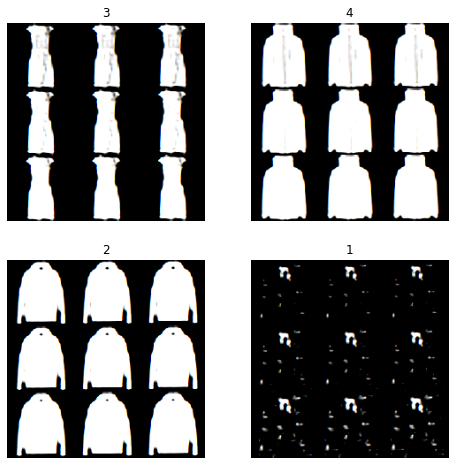

In [29]:
#-- Visualizamos los datos
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15].reshape(224,224,3))
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [30]:
#--- Convetimos las listas con los datos a tensores de torch
import torch
from torch.autograd import Variable

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([2750, 3, 224, 224])

In [31]:
#-- Creamos el DataLoader

batch_size = 32

train_ds = torch.utils.data.TensorDataset(X_train, Y_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

### Voy a utilizar el modelo pre-entrenado de resnet18. El motivo es que aprendimos a usarlo bien durante la clase y quisiera no arriesgarme mucho mientras consigo que el codigo corra

In [32]:
#--- Seleccionamos y cargamos el modelo
import torch

model = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)
model

Using cache found in /root/.cache/torch/hub/pytorch_vision_master


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
#--- Congelamos los pesos en las capaz del modelo para que no se actualicen
for p in model.parameters():
    p.requires_grad = False

#--- Definimos el número de clases
out_dim = 10

#--- Reescribimos la nueva capa de salida con el nuevo dataset
model.fc = torch.nn.Sequential(
  torch.nn.Linear(model.fc.in_features, out_dim)
)


model.load_state_dict(model.state_dict())

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [34]:
!pip install hiddenlayer

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:715: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


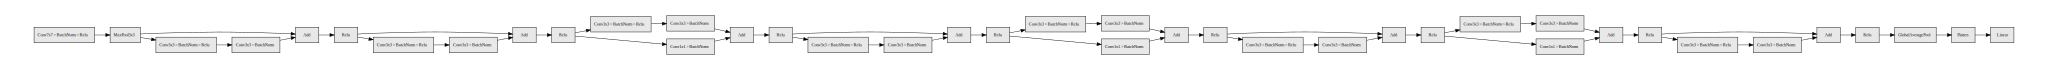

In [36]:
#--- Visualizamos la estructura de nuestra CNN

import hiddenlayer as hl

hl.build_graph(model, torch.zeros([64,3,264,264]))

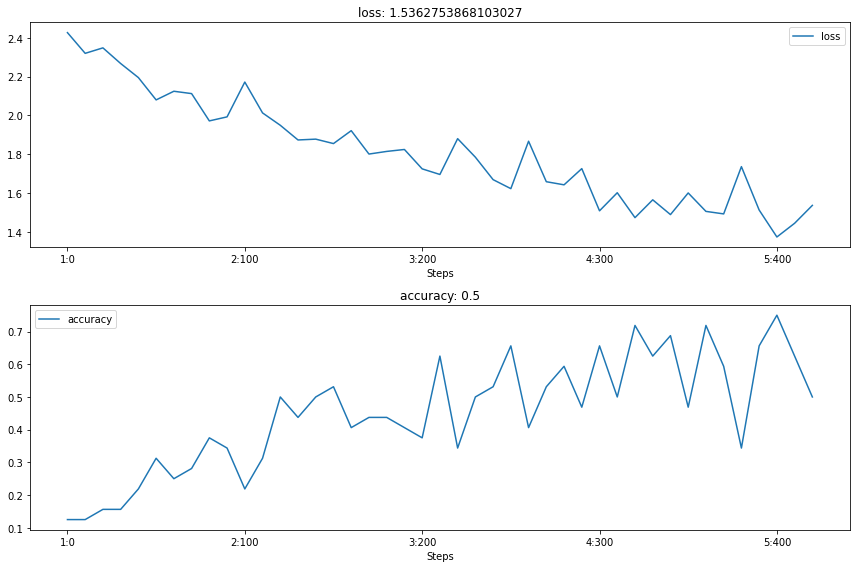

In [37]:
#--- Creamos variables para almacenar los scores en cada época 

model = model.cuda()

model.train()

#--- Definimos nuestro criterio de evaluación y el optimizador 
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.1)
criterion = torch.nn.CrossEntropyLoss()


#--- Entrenamos el modelo usando únicamente 5 épocas
n_epochs = 5

history = hl.History()
canvas = hl.Canvas()

iter = 0

for epoch in range(n_epochs):
  for batch_idx, (X_train_batch, Y_train_batch) in enumerate(train_dl):
    # Pasamos os datos a 'cuda'
    
    X_train_batch = X_train_batch.cuda()
    Y_train_batch = Y_train_batch.cuda()

    # Realiza una predicción
    Y_pred = model(X_train_batch)

    # Calcula el loss
    loss = criterion(Y_pred, Y_train_batch)

    Y_pred = torch.argmax(Y_pred, 1)

    # Calcula el accuracy
    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if iter%10 == 0:
        #-- Visualizamos la evolución de los score loss y accuracy
        history.log((epoch+1, iter), loss=loss, accuracy=acc)
        with canvas:
          canvas.draw_plot(history["loss"])
          canvas.draw_plot(history["accuracy"])

    iter += 1
    del X_train_batch, Y_train_batch, Y_pred

In [38]:
del train_ds
del train_dl

In [39]:

#-- Validamos el modelo
from sklearn.metrics import f1_score

model.cpu()
model.eval()

Y_pred = model(X_test)
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print( 'Loss:{:.2f}, F1:{:.2f}, Acc:{:.2f}'.format(loss.item(), f1, acc ) )

Loss:1.41, F1:0.66, Acc:0.67


In [40]:

from sklearn.metrics import confusion_matrix

def CM(Y_true, Y_pred, classes, lclasses=None):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  if lclasses == None:
    lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()

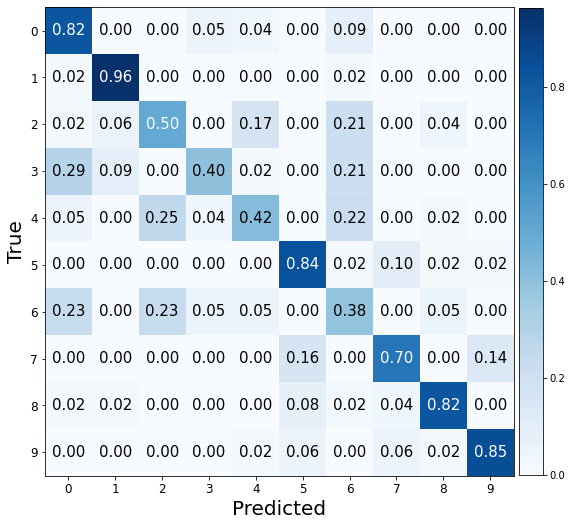

In [41]:
CM(Y_test, Y_pred, 10)

Resnet18 consiste de 5 capas <br>
La primera capa recibe 224$\cdot$224$\cdot$3 caracteristicas<br>
La última capa entrega 10 caracteristicas. Que son las 10 clasificaciones que necesitamos

El mayor factor limitante durante esta entrega fue conseguir un balance entre la cantidad de datos y la ram para que la instancía no fallará. Por esto la cantidad de datos el muy baja y por lo tanto tenemos tantos problemas que se ven reflejados en los puntajes<br>
Loss:1.41, F1:0.66, Acc:0.67

Vemos que en las categorias que más se confunde es en 6 (Shirt),4 (Coat),3 (Dress),2 (Pullover). en ese orden. Creo que también es debido a que al pasar todo a escala de grises las imagenes de ropa perdieron detalle y son más duras de distinguir